In [89]:
import numpy as np
import pandas as pd
import librosa as lib
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,multilabel_confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix


## Importar los rttm y convertirlos en un df

In [90]:
name = "dantec-a1-nsm"

In [104]:
df_resultados = pd.read_csv(f"resultados/{name}/df_results_{name}.csv")

# Lista de columnas que queremos verificar
cols_elan = ["Elan_KCHI", "Elan_OCH", "Elan_FEM", "Elan_MAL", "Elan_ELE"]
cols_diar = ["Diar_KCHI", "Diar_OCH", "Diar_FEM", "Diar_MAL", "Diar_SPEECH"]
# Crear la nueva columna Elan_NSpeech
df_resultados["Elan_SIL"] = (df_resultados[cols_elan].eq(0).all(axis=1)).astype(int)
df_resultados["Diar_SIL"] = 1 - df_resultados["Diar_SPEECH"]
df_resultados["Diar_ELE"] = 0

In [105]:
df_resultados

,Elan_KCHI,Elan_OCH,Elan_FEM,Elan_MAL,Elan_ELE,Diar_KCHI,Diar_OCH,Diar_FEM,Diar_MAL,Diar_SPEECH,Elan_SIL,Diar_SIL,Diar_ELE
0,0,0,0,0,0,0,0,1,0,1,1,0,0
1,0,0,0,0,0,0,0,1,0,1,1,0,0
2,0,0,0,0,0,0,0,1,0,1,1,0,0
3,0,0,0,0,0,0,0,1,0,1,1,0,0
4,0,0,0,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179997,0,0,1,0,0,0,0,0,0,0,0,1,0
179998,0,0,1,0,0,0,0,0,0,0,0,1,0
179999,0,0,1,0,0,0,0,0,0,0,0,1,0
180000,0,0,1,0,0,0,0,0,0,0,0,1,0


In [106]:
# Definir las etiquetas
labels = ['KCHI', 'OCH', 'FEM', 'MAL', 'ELE','SIL']

# Extraer las etiquetas verdaderas y predichas
y_true = df_resultados[['Elan_KCHI', 'Elan_OCH', 'Elan_FEM', 'Elan_MAL', 'Elan_ELE','Elan_SIL']].values
y_pred = df_resultados[['Diar_KCHI', 'Diar_OCH', 'Diar_FEM', 'Diar_MAL','Diar_ELE','Diar_SIL']].values

# Calcular la matriz de confusión multilabel
conf_matrix = multilabel_confusion_matrix(y_true, y_pred)

# Mostrar la matriz de confusión para cada etiqueta
for i, label in enumerate(labels):
    print(f"Matriz de confusión para la etiqueta {label}:")
    print(conf_matrix[i])
    print()

# Opcionalmente, puedes imprimir un informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_true, y_pred, target_names=labels))


Matriz de confusión para la etiqueta KCHI:
[[149869   5586]
 [  9018  15529]]

Matriz de confusión para la etiqueta OCH:
[[180002      0]
 [     0      0]]

Matriz de confusión para la etiqueta FEM:
[[136266  10803]
 [ 14643  18290]]

Matriz de confusión para la etiqueta MAL:
[[157163   7625]
 [  7926   7288]]

Matriz de confusión para la etiqueta ELE:
[[168002      0]
 [ 12000      0]]

Matriz de confusión para la etiqueta SIL:
[[51775 23523]
 [17889 86815]]

Informe de clasificación:
              precision    recall  f1-score   support

        KCHI       0.74      0.63      0.68     24547
         OCH       0.00      0.00      0.00         0
         FEM       0.63      0.56      0.59     32933
         MAL       0.49      0.48      0.48     15214
         ELE       0.00      0.00      0.00     12000
         SIL       0.79      0.83      0.81    104704

   micro avg       0.73      0.68      0.70    189398
   macro avg       0.44      0.42      0.43    189398
weighted avg       0.

C:\Users\pablo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pablo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pablo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


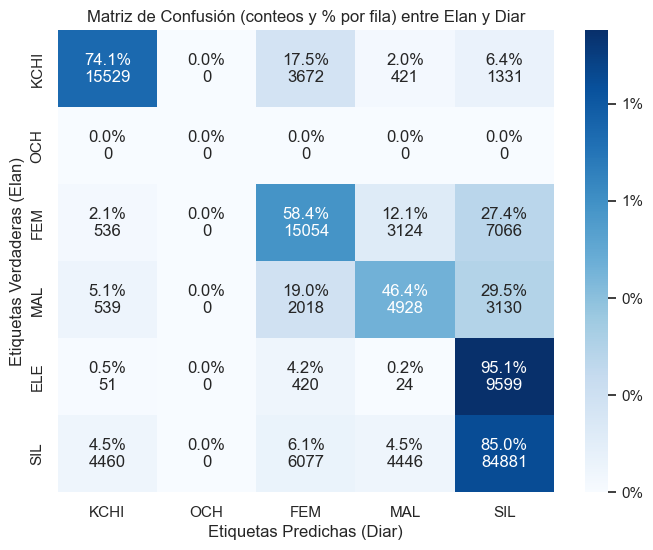

In [107]:
def multilabel_to_singlelabel(y_multilabel):
    single_labels = []
    for row in y_multilabel:
        indices = np.where(row == 1)[0]
        if len(indices) == 0:
            single_labels.append(-1)  # Sin etiqueta
        else:
            # Si hay múltiples etiquetas, definir una política (aquí: primera encontrada)
            single_labels.append(indices[0])
    return np.array(single_labels)

y_true = multilabel_to_singlelabel(y_true)
y_pred = multilabel_to_singlelabel(y_pred)

# --- 2) Filtrar instancias sin etiqueta ---
valid_indices = y_true != -1
y_true = y_true[valid_indices]
y_pred = y_pred[valid_indices]

# --- 3) Matrices: conteos y normalizada ---
labels_idx = range(len(labels))

cm_counts = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize=None)
cm_norm   = confusion_matrix(y_true, y_pred, labels=labels_idx, normalize='true')

cm_counts_df = pd.DataFrame(cm_counts, index=labels, columns=labels)
cm_norm_df   = pd.DataFrame(cm_norm,   index=labels, columns=labels)

# --- 4) Ocultar SOLO la columna 'ELE' en predichas (X), mantener fila 'ELE' en verdaderas (Y) ---
if 'ELE' in cm_counts_df.columns:
    cm_counts_df = cm_counts_df.drop(columns=['ELE'])
    cm_norm_df   = cm_norm_df.drop(columns=['ELE'])

# --- 5) Anotaciones: "conteo\n(%)" ---
annot = (cm_norm_df*100).round(1).astype(str) + "%" + "\n" + cm_counts_df.astype(int).astype(str) 

# --- 6) Graficar con porcentajes como intensidad y conteos+% como texto ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm_df,                # valores para el color (proporciones por fila)
    annot=annot,               # texto: conteos + %
    fmt='',                    # el texto ya viene como string
    cmap='Blues',
    cbar_kws={'format': '%.0f%%'}  # barra de color en %
)

plt.title('Matriz de Confusión (conteos y % por fila) entre Elan y Diar')
plt.ylabel('Etiquetas Verdaderas (Elan)')
plt.xlabel('Etiquetas Predichas (Diar)')

# --- 7) Guardado robusto ---
os.makedirs(f'resultados/{name}', exist_ok=True)
plt.savefig(f'resultados/{name}/matriz_confusion_{name}.png', dpi=300, bbox_inches='tight')
plt.show()

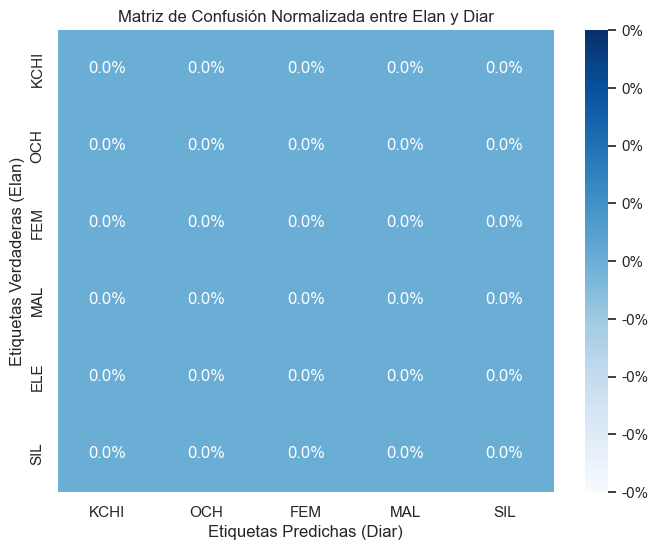

In [108]:
# Conversión de etiquetas multilabel a etiquetas de clase única (mismo código que antes)
def multilabel_to_singlelabel(y_multilabel):
    single_labels = []
    for row in y_multilabel:
        indices = np.where(row == 1)[0]
        if len(indices) == 0:
            single_labels.append(-1)  # Sin etiqueta
        else:
            # Si hay múltiples etiquetas, puedes decidir cómo manejarlas.
            # Aquí, tomamos la primera etiqueta encontrada.
            single_labels.append(indices[0])
    return np.array(single_labels)

y_true = multilabel_to_singlelabel(y_true)
y_pred = multilabel_to_singlelabel(y_pred)

# Filtrar las instancias sin etiqueta
valid_indices = y_true != -1
y_true = y_true[valid_indices]
y_pred = y_pred[valid_indices]

# Calcular la matriz de confusión normalizada
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)), normalize='true')

# Crear un DataFrame para la matriz de confusión
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Eliminar SOLO la columna 'ELE' de las predicciones
cm_df = cm_df.drop(columns=['ELE'])

# Crear las anotaciones con porcentajes
annot = cm_df.applymap(lambda x: '{0:.1f}%'.format(x*100))


# Crear el gráfico de la matriz de confusión con porcentajes
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=annot, fmt='', cmap='Blues', cbar_kws={'format': '%.0f%%'})
plt.title('Matriz de Confusión Normalizada entre Elan y Diar')
plt.ylabel('Etiquetas Verdaderas (Elan)')
plt.xlabel('Etiquetas Predichas (Diar)')

# Guardar la figura como un archivo PNG
plt.savefig(f'resultados/{name}/matriz_confusion_{name}.png', dpi=300, bbox_inches='tight')

plt.show()


In [109]:
cm_df

,KCHI,OCH,FEM,MAL,SIL
KCHI,0,0,0,0,0
OCH,0,0,0,0,0
FEM,0,0,0,0,0
MAL,0,0,0,0,0
ELE,0,0,0,0,0
SIL,0,0,0,0,0


In [110]:
df_results=df_resultados
df_results

,Elan_KCHI,Elan_OCH,Elan_FEM,Elan_MAL,Elan_ELE,Diar_KCHI,Diar_OCH,Diar_FEM,Diar_MAL,Diar_SPEECH,Elan_SIL,Diar_SIL,Diar_ELE
0,0,0,0,0,0,0,0,1,0,1,1,0,0
1,0,0,0,0,0,0,0,1,0,1,1,0,0
2,0,0,0,0,0,0,0,1,0,1,1,0,0
3,0,0,0,0,0,0,0,1,0,1,1,0,0
4,0,0,0,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179997,0,0,1,0,0,0,0,0,0,0,0,1,0
179998,0,0,1,0,0,0,0,0,0,0,0,1,0
179999,0,0,1,0,0,0,0,0,0,0,0,1,0
180000,0,0,1,0,0,0,0,0,0,0,0,1,0


In [111]:
# Cálculo de precisión, recall y F1-score
types = ['KCHI', 'OCH', 'FEM', 'MAL',"SIL"]

# Inicializar listas para almacenar las métricas
metrics = {
    'Tipo': [],
    'Precisión': [],
    'Recall': [],
    'F1-score': []
}

print("\nCalculando métricas de precisión, recall y F1-score:")
for t in tqdm(types, desc="Procesando tipos"):
    y_true = df_results['Elan_' + t]
    y_pred = df_results['Diar_' + t]
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Almacenar las métricas
    metrics['Tipo'].append(t)
    metrics['Precisión'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1-score'].append(f1)
    
    # Imprimir los resultados
    print(f"\nResultados para el tipo {t}:")
    print(f"Precisión: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

# Crear DataFrame de métricas
df_metrics = pd.DataFrame(metrics)


Calculando métricas de precisión, recall y F1-score:


Procesando tipos:  20%|██        | 1/5 [00:00<00:00,  9.57it/s]


Resultados para el tipo KCHI:
Precisión: 0.7354
Recall: 0.6326
F1-score: 0.6802


Procesando tipos:  40%|████      | 2/5 [00:00<00:00,  9.42it/s]


Resultados para el tipo OCH:
Precisión: 0.0000
Recall: 0.0000
F1-score: 0.0000

Resultados para el tipo FEM:
Precisión: 0.6287
Recall: 0.5554
F1-score: 0.5898


Procesando tipos:  80%|████████  | 4/5 [00:00<00:00,  9.86it/s]


Resultados para el tipo MAL:
Precisión: 0.4887
Recall: 0.4790
F1-score: 0.4838


Procesando tipos: 100%|██████████| 5/5 [00:00<00:00,  9.98it/s]


Resultados para el tipo SIL:
Precisión: 0.7868
Recall: 0.8291
F1-score: 0.8074


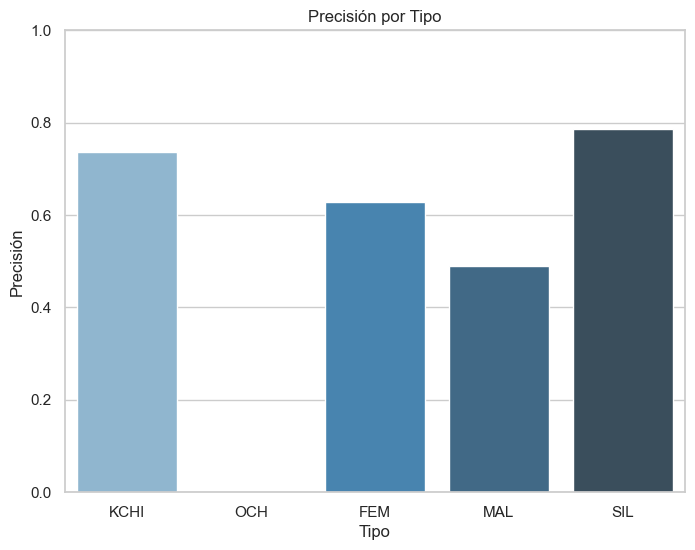

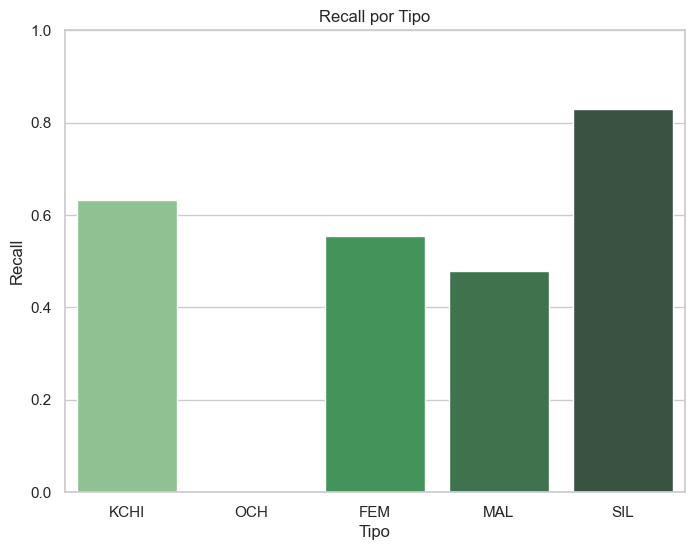

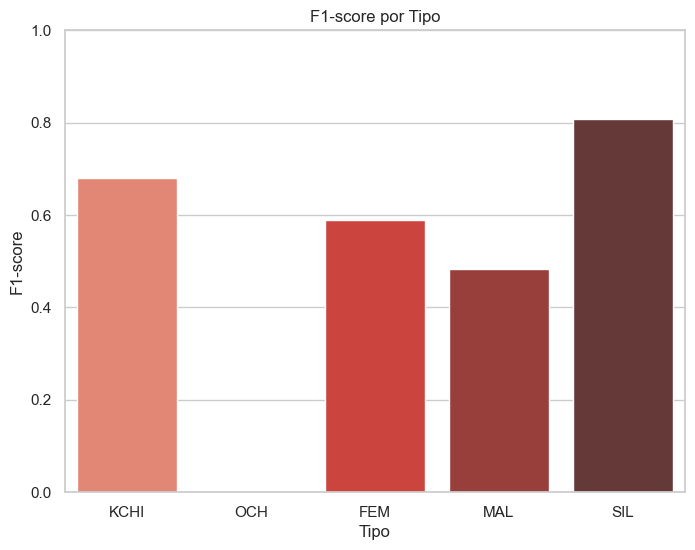

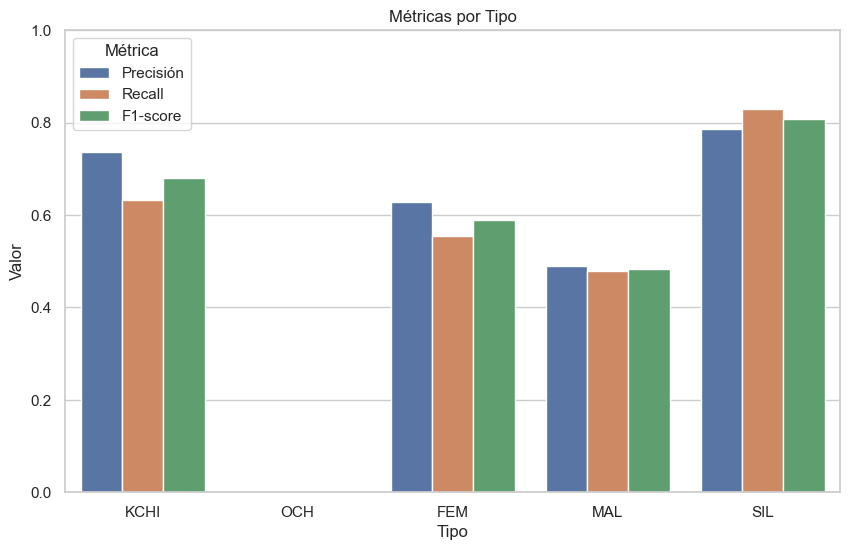

In [100]:
# Generar gráficos
sns.set(style="whitegrid")

# Gráfico de barras para Precisión
plt.figure(figsize=(8, 6))
sns.barplot(x='Tipo', y='Precisión', data=df_metrics, palette='Blues_d')
plt.title('Precisión por Tipo')
plt.ylim(0, 1)
plt.ylabel('Precisión')

# Guardar la figura como un archivo PNG
plt.savefig(f'resultados/{name}/precision_{name}.png', dpi=300, bbox_inches='tight')

plt.show()

# Gráfico de barras para Recall
plt.figure(figsize=(8, 6))
sns.barplot(x='Tipo', y='Recall', data=df_metrics, palette='Greens_d')
plt.title('Recall por Tipo')
plt.ylim(0, 1)
plt.ylabel('Recall')

# Guardar la figura como un archivo PNG
plt.savefig(f'resultados/{name}/recall_{name}.png', dpi=300, bbox_inches='tight')

plt.show()

# Gráfico de barras para F1-score
plt.figure(figsize=(8, 6))
sns.barplot(x='Tipo', y='F1-score', data=df_metrics, palette='Reds_d')
plt.title('F1-score por Tipo')
plt.ylim(0, 1)
plt.ylabel('F1-score')
# Guardar la figura como un archivo PNG
plt.savefig(f'resultados/{name}/f1score_{name}.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico combinado
df_metrics_melted = pd.melt(df_metrics, id_vars=['Tipo'], value_vars=['Precisión', 'Recall', 'F1-score'], var_name='Métrica', value_name='Valor')

plt.figure(figsize=(10, 6))
sns.barplot(x='Tipo', y='Valor', hue='Métrica', data=df_metrics_melted)
plt.title('Métricas por Tipo')
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.legend(title='Métrica')

# Guardar la figura como un archivo PNG
plt.savefig(f'resultados/{name}/combinado_{name}.png', dpi=300, bbox_inches='tight')

plt.show()


In [85]:
# Seleccionar las columnas que empiezan con "Diar_"
diar_columns = [col for col in df_resultados.columns if col.startswith('Diar_')]

# Cambiar los valores de 1 a 0.8 en esas columnas
df_resultados[diar_columns] = df_resultados[diar_columns].replace(1, 0.8)

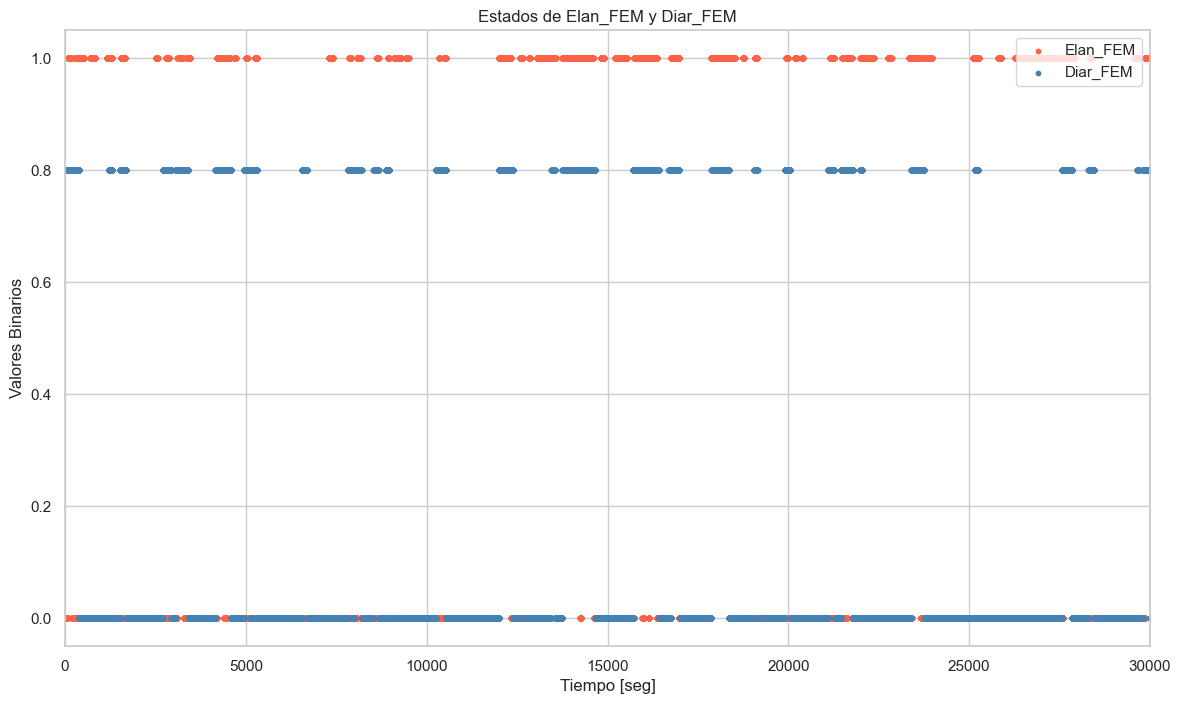

In [86]:
# Definir las columnas que deseas graficar
columns_to_plot = ['Elan_FEM', 'Diar_FEM']

# Definir colores contrastantes
colors = ['#FF6347', '#4682B4']  # Tomato y SteelBlue

# Crear la gráfica de dispersión para mostrar solo los estados sin transiciones
plt.figure(figsize=(14, 8))

# Graficar solo los puntos donde el valor es 1
for i, column in enumerate(columns_to_plot):
    plt.scatter(df_resultados.index, df_resultados[column], label=column, color=colors[i], s=10)

# Configuración del gráfico
plt.title('Estados de Elan_FEM y Diar_FEM')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Valores Binarios')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim(0, 30000)

# Guardar la figura como un archivo PNG
# plt.savefig(f'binarios_{name}.png', dpi=300, bbox_inches='tight')
# Mostrar la gráfica
plt.show()


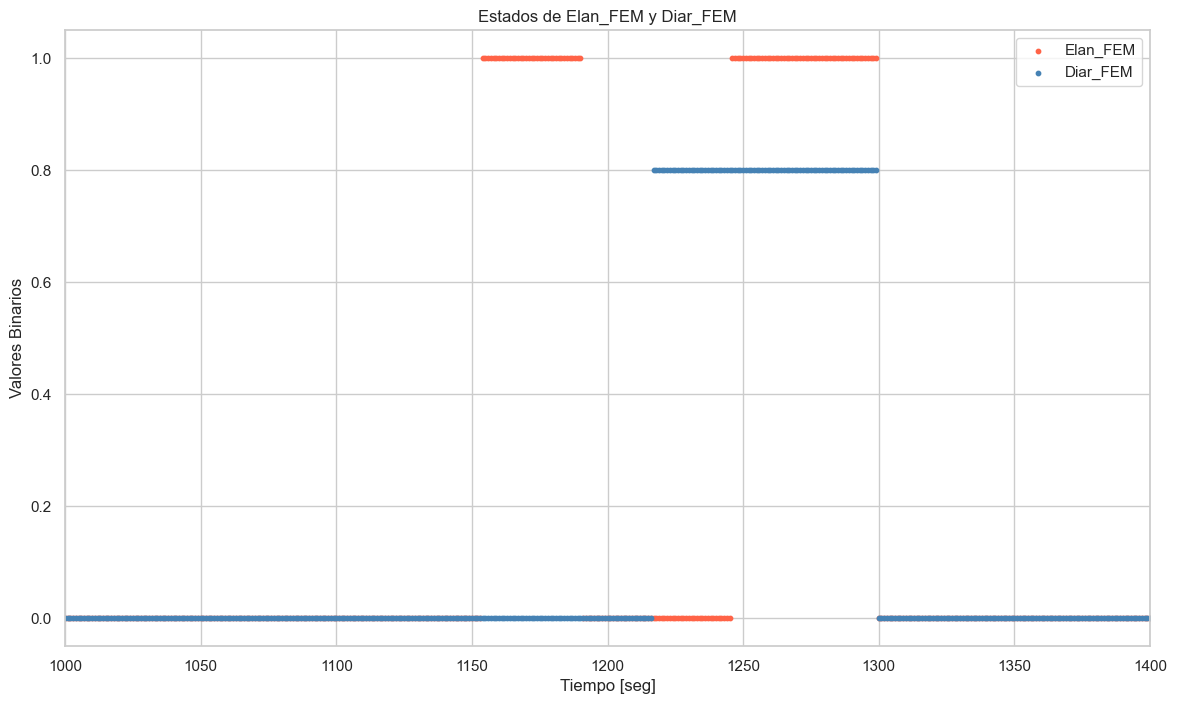

In [87]:
# Definir las columnas que deseas graficar
columns_to_plot = ['Elan_FEM', 'Diar_FEM']

# Definir colores contrastantes
colors = ['#FF6347', '#4682B4']  # Tomato y SteelBlue

# Crear la gráfica de dispersión para mostrar solo los estados sin transiciones
plt.figure(figsize=(14, 8))

# Graficar solo los puntos donde el valor es 1
for i, column in enumerate(columns_to_plot):
    plt.scatter(df_resultados.index, df_resultados[column], label=column, color=colors[i], s=10)

# Configuración del gráfico
plt.title('Estados de Elan_FEM y Diar_FEM')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Valores Binarios')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim(1000, 1400)

# Guardar la figura como un archivo PNG
# plt.savefig(f'binariosShort_{name}.png', dpi=300, bbox_inches='tight')

# Mostrar la gráfica
plt.show()

In [73]:
# --- 1) Definir etiquetas ---
labels_true = ['KCHI', 'OCH', 'FEM', 'MAL', 'ELE', 'SIL']     # pueden aparecer en y_true
labels_pred = ['KCHI', 'OCH', 'FEM', 'MAL', 'SIL']            # NUNCA incluye 'ELE'

# --- 2) Extraer multilabels ---
y_true = df_resultados[['Elan_KCHI','Elan_OCH','Elan_FEM','Elan_MAL','Elan_ELE','Elan_SIL']].values
# y_pred sin ELE
y_pred_noele = df_resultados[['Diar_KCHI','Diar_OCH','Diar_FEM','Diar_MAL','Diar_SIL']].values

# --- 3) (Opcional) Métricas multilabel que requieren misma forma ---
# Creamos y_pred_full con una columna de ceros para ELE en la misma posición que en y_true
# Orden final debe matchear labels_true
import numpy as np
idx_ele_true = labels_true.index('ELE')  # posición de ELE en y_true
# insertar columna de ceros en esa posición
y_pred_full = np.insert(y_pred_noele, idx_ele_true, 0, axis=1)

# Matriz de confusión multilabel (misma forma)
conf_matrix = multilabel_confusion_matrix(y_true, y_pred_full)
for i, label in enumerate(labels_true):
    print(f"Matriz de confusión para la etiqueta {label}:")
    print(conf_matrix[i], '\n')

print("Informe de clasificación (multilabel):")
print(classification_report(y_true, y_pred_full, target_names=labels_true))

# --- 4) Conversión a single-label (sin ELE en predicciones) ---
def multilabel_to_singlelabel(y_multilabel):
    single_labels = []
    for row in y_multilabel:
        idx = np.where(row == 1)[0]
        single_labels.append(idx[0] if len(idx) else -1)
    return np.array(single_labels)

# a) Verdaderos con todas las clases (incluye ELE)
y_true_sl_idx = multilabel_to_singlelabel(y_true)  # índices respecto de labels_true

# b) Predicciones solo entre labels_pred (sin ELE)
y_pred_sl_idx = multilabel_to_singlelabel(y_pred_noele)  # índices respecto de labels_pred

# Filtramos instancias sin etiqueta verdadera
valid = y_true_sl_idx != -1
y_true_sl_idx = y_true_sl_idx[valid]
y_pred_sl_idx = y_pred_sl_idx[valid]

# Mapear a nombres para poder hacer crosstab rectangular
y_true_sl = [labels_true[i] for i in y_true_sl_idx]
y_pred_sl = [labels_pred[i] for i in y_pred_sl_idx if i != -1]

# Asegurar mismas longitudes (si alguna pred fue -1, la descartamos junto con su true)
# (Esto es raro; si puede ocurrir, mejor filtrar así:)
mask_pred_valid = [i != -1 for i in y_pred_sl_idx]
y_true_sl = [lab for lab, ok in zip(y_true_sl, mask_pred_valid) if ok]
y_pred_sl = [labels_pred[i] for i, ok in zip(y_pred_sl_idx, mask_pred_valid) if ok]

import pandas as pd

# --- 5) Matriz de confusión rectangular (filas: todas las verdaderas; cols: solo pred sin ELE) ---
cm_df = pd.crosstab(
    pd.Categorical(y_true_sl, categories=labels_true),
    pd.Categorical(y_pred_sl, categories=labels_pred),
    normalize='index'  # normaliza por fila
).fillna(0.0)

# --- 6) Plot ---
import matplotlib.pyplot as plt
import seaborn as sns

annot = cm_df.applymap(lambda x: f'{x*100:.1f}%')

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=annot, fmt='', cmap='Blues', cbar_kws={'format': '%.0f%%'})
plt.title('Matriz de Confusión Normalizada')
plt.ylabel('Etiquetas Verdaderas (Elan)')
plt.xlabel('Etiquetas Predichas (Diar)')
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.savefig(f'resultados/{name}/matriz_confusion_{name}_rectangular_sin_ELE_en_pred.png',
            dpi=300, bbox_inches='tight')
plt.show()


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets